# 🧭 Project CX: Travel agent tool classifier

Welcome to your first ML project coding exercise of the week! You are building an intelligent routing system that solves a real travel industry challenge: automatically directing booking requests to the right service API.

A user might type *"Find me a hotel in Zurich for the weekend"* or *"Book a direct flight to Tokyo"* — and your classifier needs to instantly decide which backend tool to call: a flight booker, a hotel booker, or a car rental service. This is the core intelligence behind modern agentic travel apps.

**Pipeline:**

You'll walk through the complete Machine Learning Engineer pipeline:

1. 🗂️ **Load the data** — Get your travel booking dataset ready
2. 🔍 **Inspect the dataset** — Understand what you're working with
3. 📊 **Visualize the embeddings** — See your data in 2D space using PCA
4. 🧱 **Define architecture** — Build your model, dataset, and metrics
5. 🏋️ **Train the classifier** — Watch your MLP learn the routing patterns
6. 📋 **Evaluate performance** — Test how well it routes on unseen data
7. 🚀 **Live routing demo** — Try it yourself with real travel requests!

By the end, you will have trained an MLP classifier that intelligently routes travel plans between the 3 booking classes: flights, hotels, and activities. This is the core intelligence behind agentic travel apps where users describe their dream vacation and the system automatically books everything with a single click.

---
## 1 🗂️ Load the Data

We load pre-computed 384-dim sentence embeddings from CSVs from the `data-generation/` directory. Each row contains an embedding vector (columns `"0"`–`"383"`), a string label (`Flight`, `Hotel`, or `CarRental`), and the original sentence.

In [ ]:
#@title ▶️ Run this cell to download the data and clone the repo (click to expand code)
!git clone -b week1/tool-picker/demo2 https://github.com/eth-bmai-fs26/project.git
!git fetch && git checkout week1/tool-picker/demo2
%cd project/week1/tool-picker

Cloning into 'project'...
remote: Enumerating objects: 420, done.
remote: Counting objects: 100% (216/216), done.
remote: Compressing objects: 100% (158/158), done.
remote: Total 420 (delta 93), reused 165 (delta 54), pack-reused 204 (from 1)
Receiving objects: 100% (420/420), 28.33 MiB | 19.55 MiB/s, done.
Resolving deltas: 100% (157/157), done.
Already on 'week1/tool-picker/demo2'
Your branch is up to date with 'origin/week1/tool-picker/demo2'.
/content/project/tool-picker/project/tool-picker


In [ ]:
import os, sys

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

DATA_DIR = os.path.join(os.getcwd(), "data")

# Store file paths for each data split (train / validation / test)
train_path = os.path.join(DATA_DIR, "train.csv")
val_path = os.path.join(DATA_DIR, "val.csv")
test_path = os.path.join(DATA_DIR, "test.csv")

---

### How did sentences become numbers?

Before training a classifier, we need to turn each sentence into something a model can work with: a list of numbers called an **embedding**.

Our classifier will work by learning to categorize these sentence embeddings rather than the raw text itself.

Think of it like this:

> **"Book a flight to Paris"** → `[0.12, -0.03, 0.47, …, 0.08]` (384 numbers)

A small pretrained language model reads the sentence and compresses its meaning into a fixed-size vector of 384 numbers. Sentences that mean similar things end up with similar vectors. For example, *"Reserve a plane ticket to Rome"* would land close to *"Book a flight to Paris"* in this 384-dimensional space, while *"Find me a hotel downtown"* would be farther away.

You don't need to run this step yourself. It was already done ahead of time, and the CSVs you loaded above contain the resulting embedding vectors.

---
## 2 🔍 Load & Inspect

Read the three CSVs into DataFrames and print shapes, class distribution, and a preview of the first few rows to verify the data looks correct.

In [ ]:
import numpy as np
import pandas as pd

LABEL_NAMES = {0: "FLIGHT_BOOKER", 1: "HOTEL_BOOKER", 2: "CAR_RENTAL_BOOKER"}
LABEL_MAP = {"Flight": 0, "Hotel": 1, "CarRental": 2}

train_df = pd.read_csv(train_path, index_col=0)
val_df   = pd.read_csv(val_path,   index_col=0)
test_df  = pd.read_csv(test_path,  index_col=0)

for df in (train_df, val_df, test_df):
    df["label"] = df["label"].map(LABEL_MAP)

print("Overview of the dataset:")
print(f"Train shape: {train_df.shape}")
print(f"Val shape:   {val_df.shape}")
print(f"Test shape:  {test_df.shape}")
print(f"\nClass distribution (train):")
print(train_df["label"].value_counts().sort_index().rename(LABEL_NAMES))
train_df.head()

Train shape: (4664, 386)
Val shape:   (583, 386)
Test shape:  (583, 386)

Class distribution (train):
label
FLIGHT_BOOKER        1599
HOTEL_BOOKER         1562
CAR_RENTAL_BOOKER    1503
Name: count, dtype: int64


,sentence,label,0,1,2,3,4,5,6,7,...,374,375,376,377,378,379,380,381,382,383
4762,Can anyone suggest a good way to negotiate the...,1,0.046862,0.055410,-0.059908,0.041471,-0.097327,0.034237,-0.013401,-0.018406,...,-0.012981,-0.071004,0.001557,0.015660,-0.006875,0.050122,-0.031154,-0.006029,-0.120180,-0.011953
3049,I should check if my preferred airline offers ...,0,0.071417,-0.039349,0.007058,0.048351,-0.014526,0.069662,-0.000907,-0.007867,...,-0.020672,-0.034488,-0.068156,-0.023059,-0.006910,0.067927,0.057031,-0.059272,-0.067639,-0.021172
1721,It's a good idea to read the fine print and un...,2,0.057536,-0.006204,0.042967,-0.029328,0.017914,0.062071,-0.014321,0.018624,...,0.040093,0.001844,0.013997,-0.043470,-0.024545,0.030553,-0.011794,0.085530,0.024879,0.008744
3332,Make sure to check the airport's baggage polic...,0,0.103429,-0.029298,0.047439,0.016657,-0.001705,-0.040284,-0.044104,-0.039553,...,0.012132,0.006198,-0.032831,0.003732,0.019031,0.062110,-0.041731,0.009832,-0.040126,-0.055118
252,You may need to purchase additional insurance ...,2,0.071755,-0.013409,0.099655,0.014046,0.030856,0.041443,-0.012810,0.024744,...,-0.018933,0.022961,0.001270,-0.045854,-0.043700,0.071622,-0.067477,-0.039455,0.003947,-0.005166


#### 🔎 What to look for here

A few things to notice in the output above:

- **Shape `(4664, 386)`** — 4664 training samples, each with 384 embedding dimensions + the `label` column + the `sentence` column. The validation and test sets are much smaller (583 each), which is a common 80/10/10 split.
- **Balanced classes** — Each class has roughly 1555 samples in training (~33% each). This is great! With balanced classes we don't need to worry about the model favoring one class over others, and plain **accuracy** is a fair metric. If classes were imbalanced (e.g. 90% flights, 5% hotels, 5% cars), accuracy would be misleading and we'd need metrics like F1-score or balanced accuracy.
- **The DataFrame preview** — Each row is one training example. The `sentence` column holds the original text, `label` is the integer class (0/1/2), and columns `0` through `383` hold the 384 embedding values. The embedding values are small floating-point numbers roughly in the range [-0.15, 0.15], which is typical for normalized sentence embeddings.

---
## 3 📊 - 🎯: Visualize the embeddings

**Exercise:** Project the 384-dim embeddings down to 2D so we can visualize them.

Your task:
1. Create a `PCA` object that reduces to **2 components** (use `random_state=42`)
2. Call `fit_transform` on `X_train` to get the 2D coordinates

The plotting code is already provided — once you fill in the two lines, run the cell to see your scatter plot!

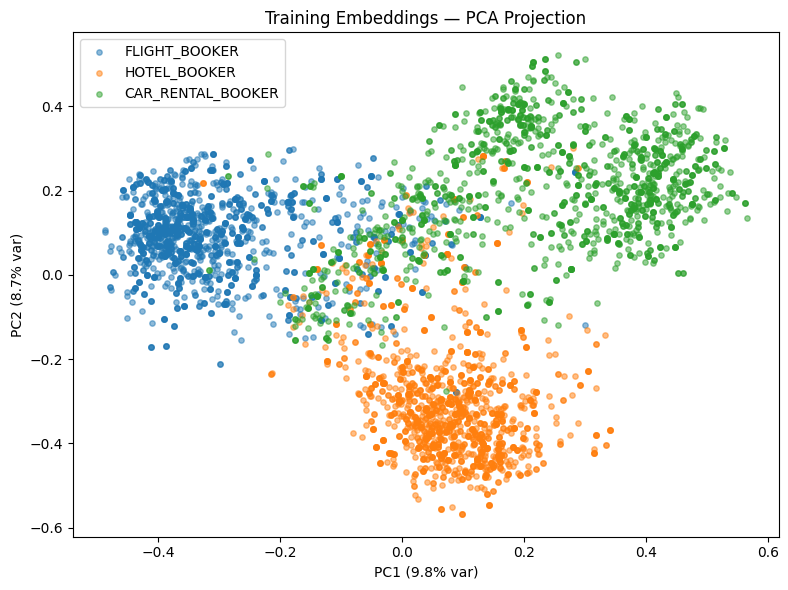

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

emb_cols = []
for col_name in train_df.columns:
    if str(col_name).isdigit():
        emb_cols.append(col_name)
emb_cols.sort(key=int)
X_train = train_df[emb_cols].values
y_train = train_df["label"].values

# 🎯 TODO: Create a PCA object that projects down to 2 components (you only need to fill in the n_components and random_state arguments)
# Hint: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA
pca = ...

# 🎯 TODO: Call fit_transform method of pca on X_train to get the 2D projection
# Hint: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA.fit_transform
X_2d = ...

plt.figure(figsize=(8, 6))
for k in range(3):
    mask = y_train == k
    plt.scatter(X_2d[mask, 0], X_2d[mask, 1], label=LABEL_NAMES[k], alpha=0.5, s=15)

plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%} var)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%} var)")
plt.title("Training Embeddings — PCA Projection")
plt.legend()
plt.tight_layout()
plt.show()

#### 📖 Reading the PCA plot

**What is PCA doing here?** Each training sample lives in a 384-dimensional space (one dimension per embedding feature). We obviously can't visualize 384 dimensions, so PCA (Principal Component Analysis) finds the two directions in that space that capture the most variance and projects every point onto them. Think of it as finding the "best camera angle" to photograph a 3D object in 2D — except here we're going from 384D to 2D.

**What to look for:**
- **Distinct clusters** — If the three classes form well-separated blobs, that's a strong signal that a simple classifier will work well. The embedding model has already done most of the heavy lifting by mapping semantically similar sentences to nearby vectors.
- **Overlap between clusters** — Where clusters overlap, those are the regions where the classifier will struggle. Misclassified samples at test time will almost always come from these boundary regions.
- **Explained variance** — The axis labels show how much of the total variance each principal component captures (e.g. "PC1 (15.2% var)"). Don't be alarmed if these percentages seem low — with 384 dimensions, the information is spread across many axes. Even 10-15% per axis is meaningful.

> **Key insight:** PCA is just a visualization tool here, not a preprocessing step. The classifier will train on the full 384-dim embeddings and can exploit structure in all dimensions, not just the two shown in the plot.

---
## 4 🧱 Model, Dataset & Metrics Definitions

### 4.1 🗃️ PyTorch Dataset + DataLoaders

We import `make_dataloaders` from `dataset.py`, which handles reading the CSVs and packaging each split (train/val/test) into a PyTorch `DataLoader`. Each `DataLoader` serves data in mini-batches during training and evaluation.

In [12]:
from lib.dataset import make_dataloaders

print("✅ Dataset & DataLoader ready.")

✅ Dataset & DataLoader ready.


#### 💡 Why wrap data in a PyTorch Dataset?

You might wonder why we don't just pass NumPy arrays directly to the model. The `Dataset` + `DataLoader` pattern gives us several things for free:

1. **Batching** — Instead of feeding all 4664 samples at once (which works here but not with larger datasets), the `DataLoader` serves them in mini-batches of 64. This controls memory usage and provides the stochastic gradient updates that help training.
2. **Shuffling** — The training `DataLoader` shuffles data each epoch, so the model doesn't memorize the order of examples. The validation and test loaders don't shuffle because evaluation order doesn't matter.
3. **Automatic tensor conversion** — The dataset returns PyTorch tensors ready for GPU/CPU computation, keeping the data pipeline clean.
4. **Scalability** — This same pattern scales from thousands of samples to millions. For huge datasets you could load from disk lazily instead of holding everything in memory.


### 4.2 🧠 - 🎯 Building the Neural Network

A minimal two-layer MLP: `Linear(d → hidden) → ReLU → Dropout → Linear(hidden → 3)`. The output layer produces one score per class — the highest score wins.

In [3]:
import torch.nn as nn


class ToolRouterMLP(nn.Module):
    """Simple two-layer MLP: Linear → ReLU → Dropout → Linear.

    Outputs raw logits.
    """

    def __init__(self, input_dim, hidden_dim=128, num_classes=3, dropout_p=0.1):
        super().__init__()
        # 🎯 TODO: Inside the nn.Sequential define the network architecture using the provided arguments
        self.network = nn.Sequential(
            nn.Linear(..., ...),
            ...,
            nn.Dropout(...),
            ...
        )

    def forward(self, x):
        # 🎯 TODO: return the output of passing x through the network called self.network
        return ...


print("✅ ToolRouterMLP ready.")

✅ ToolRouterMLP ready.


#### 🏗️ Understanding the architecture

Let's unpack what each layer does and *why* it's there:

| Layer | What it does | Why we need it |
|-------|-------------|----------------|
| `Linear(384 → 128)` | Multiplies the 384-dim input by a weight matrix to produce 128 features | Learns which combinations of embedding dimensions are useful for classification |
| `ReLU()` | Replaces negative values with zero: `max(0, x)` | Introduces **non-linearity** — without it, stacking linear layers is mathematically equivalent to a single linear layer, so the network couldn't learn complex decision boundaries |
| `Dropout(0.1)` | Randomly zeroes 10% of neurons during training | **Regularization** — prevents the network from relying too heavily on any single neuron, reducing overfitting |
| `Linear(128 → 3)` | Maps 128 hidden features to 3 output scores (one per class) | Produces the final prediction — the class with the highest score wins |

**Why no softmax at the end?** The last layer outputs one raw score per class. PyTorch's loss function handles converting these scores into probabilities internally, so we don't need to add that step ourselves.

**Why only two layers?** Our input embeddings are already highly informative (a pretrained language model produced them). The classifier just needs to learn a relatively simple decision boundary in embedding space. Adding more layers would risk overfitting on our small dataset of 480 samples.

### 4.3 📐 Metrics

Two simple evaluation tools: `accuracy` (how many predictions are correct) and `confusion_matrix` (shows which classes get confused with each other).

In [14]:
def accuracy(y_true, y_pred) -> float:
    """Fraction of correct predictions."""
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    num_correct = (y_true == y_pred).sum()
    return float(num_correct) / len(y_true)


from lib.metrics import confusion_matrix

#### 📊 Why these two metrics?

- **Accuracy** is the go-to metric when classes are balanced (and ours are, at ~33% each). It simply answers: *"What fraction of predictions are correct?"* With 3 balanced classes, a random-guessing baseline would score ~33%, so anything above that shows the model has learned something.

- **Confusion matrix** tells us *where* the model makes mistakes. Each cell `[i, j]` counts how many samples from true class `i` were predicted as class `j`. The diagonal shows correct predictions; off-diagonal entries are errors. For example, if many hotel bookings get misclassified as car rentals, the confusion matrix will reveal that pattern — something overall accuracy alone would hide.

---
## 5 🏋️ Train the classifier

### 5.1 ⚙️ Hyperparameters & Reproducibility

Set all training hyperparameters in one place and fix random seeds so you get the same results every time you run the code.

In [15]:
from lib.utils import set_seed
import torch

SEED       = 42
EPOCHS     = 20
BATCH_SIZE = 64
HIDDEN_DIM = 128
LR         = 1e-3
DROPOUT_P  = 0.1

set_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🖥️  Device: {device}")

🖥️  Device: cpu


#### 🎛️ Why these specific values?

| Hyperparameter | Value | Rationale |
|---|---|---|
| `SEED = 42` | Fixed seed | Ensures you get the same results every run — critical for debugging and reproducibility |
| `EPOCHS = 20` | 20 passes over the training data | Enough for the loss to converge on this dataset without excessive training time |
| `BATCH_SIZE = 64` | 64 samples per gradient update | With 4664 training samples, that's ~73 batches per epoch — a good balance between stable gradients and frequent updates |
| `HIDDEN_DIM = 128` | 128 hidden neurons | Gives the network enough capacity to learn the routing patterns without being so large it overfits |
| `LR = 1e-3` | Learning rate of 0.001 | The default for Adam and a solid starting point — too high causes instability, too low makes training painfully slow |
| `DROPOUT_P = 0.1` | 10% dropout rate | Light regularization as a starting point; heavier dropout (e.g. 0.3–0.5) is worth exploring if you observe overfitting |

> **Tip:** In practice, hyperparameter tuning is often the difference between a mediocre and a great model. Common strategies include grid search, random search, or more sophisticated methods like Bayesian optimization.


### 5.2 📦 DataLoaders + Model Init

Wrap the three CSVs into PyTorch `DataLoader`s and instantiate the MLP, Adam optimizer, and loss function.

In [ ]:
train_loader, val_loader, test_loader = make_dataloaders(
    train_path, val_path, test_path,
    batch_size=BATCH_SIZE,
)
input_dim = train_loader.dataset.dim

print(f"Input dim: {input_dim}")
print(f"Train: {len(train_loader.dataset)}  "
      f"Val: {len(val_loader.dataset)}  "
      f"Test: {len(test_loader.dataset)}")

# Note:     earlier on in part 4.2 you defined the ToolRouterMLP class, now you will create an instance of it
#           a class is like a blueprint for our model, and an instance is a specific model created based on that blueprint
model = ToolRouterMLP(
    input_dim=input_dim,
    hidden_dim=HIDDEN_DIM,
    num_classes=3,
    dropout_p=DROPOUT_P,
).to(device)

# 🎯 TODO: complete the missing parts to define the optimizer
# Hint: what is the optimizer trying to optimize? 
optimizer = torch.optim.Adam(..., lr=LR)

loss_fn = nn.CrossEntropyLoss()

print(f"\n{model}")

Input dim: 384
Train: 4664  Val: 583  Test: 583

ToolRouterMLP(
  (network): Sequential(
    (0): Linear(in_features=384, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=128, out_features=3, bias=True)
  )
)


#### 🧩 What we just assembled

Let's take stock of the pieces we now have ready for training:

- **DataLoaders** — Three iterators that serve mini-batches of `(embedding, label)` pairs from train/val/test splits
- **Model** — A 2-layer MLP with 49,539 trainable parameters (`384×128 + 128 + 128×3 + 3`)
- **Optimizer** — Adam, which adapts the learning rate per-parameter using running estimates of gradient mean and variance. It's the workhorse optimizer in deep learning for good reason: it works well out of the box for most problems
- **Loss function** — The standard loss for multi-class classification. It penalizes the model more when it's confidently wrong and rewards confident correct predictions

### 5.3 🔁 Training Loop

Define `train_one_epoch` and `evaluate` helper functions, then run the full training loop for  `EPOCH` epochs, printing train/val loss and accuracy each epoch.

In [ ]:
def train_one_epoch(model, loader, optimizer, loss_fn, device):
    """Train for one epoch. Returns (avg_loss, accuracy)."""
    model.train() # Set model to training mode
    total_loss = 0.0
    correct = 0
    total = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)

        # This block is the core of the training loop for one batch!
        logits = model(x)           # Forward pass: compute raw class scores (logits) from the model
        loss = loss_fn(logits, y)   # Compute cross-entropy loss between predicted logits and true labels
        optimizer.zero_grad()       # Reset gradients from the previous batch before backpropagation
        loss.backward()             # Backward pass: compute gradients of loss w.r.t. all model parameters
        optimizer.step()            # Update model parameters using the computed gradients

        # Accumulate weighted loss (multiply by batch size to undo the mean)
        batch_size = x.size(0)
        total_loss = total_loss + loss.item() * batch_size

        # Pick the class with the highest logit as the prediction
        preds = logits.argmax(dim=1)
        num_correct_in_batch = (preds == y).sum()
        correct = correct + num_correct_in_batch.item()
        total = total + batch_size

    # Return mean loss and fraction of correct predictions over the full epoch
    return total_loss / total, correct / total


def evaluate(model, loader, loss_fn, device):
    """Evaluate on a dataset. Returns (avg_loss, accuracy, y_true, y_pred)."""
    model.eval() # Set model to evaluation mode
    total_loss = 0.0
    all_true = []
    all_pred = []

    # Disable gradient tracking — we only need forward passes during evaluation
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = loss_fn(logits, y)

            batch_size = x.size(0)
            total_loss = total_loss + loss.item() * batch_size

            # Predicted class is the index with the highest logit score
            preds = logits.argmax(dim=1)
            # Collect true labels and predictions for metric computation
            all_true.extend(y.cpu().numpy())
            all_pred.extend(preds.cpu().numpy())

    total = len(all_true)
    acc = accuracy(all_true, all_pred)
    return total_loss / total, acc, all_true, all_pred


# --- run training ---
for epoch in range(1, EPOCHS + 1):
    # Train for one full pass over the training set
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, loss_fn, device)
    # Evaluate on the validation set to monitor generalisation (no weight updates)
    val_loss, val_acc, _, _ = evaluate(model, val_loader, loss_fn, device)
    print(f"Epoch {epoch:2d}/{EPOCHS}  "
          f"train_loss={train_loss:.4f}  train_acc={train_acc:.4f}  "
          f"val_loss={val_loss:.4f}  val_acc={val_acc:.4f}")

Epoch  1/20  train_loss=0.6273  train_acc=0.8896  val_loss=0.2317  val_acc=0.9417
Epoch  2/20  train_loss=0.1964  train_acc=0.9410  val_loss=0.1513  val_acc=0.9588
Epoch  3/20  train_loss=0.1512  train_acc=0.9522  val_loss=0.1252  val_acc=0.9640
Epoch  4/20  train_loss=0.1317  train_acc=0.9571  val_loss=0.1130  val_acc=0.9674
Epoch  5/20  train_loss=0.1159  train_acc=0.9618  val_loss=0.1087  val_acc=0.9640
Epoch  6/20  train_loss=0.1046  train_acc=0.9648  val_loss=0.0989  val_acc=0.9674
Epoch  7/20  train_loss=0.0940  train_acc=0.9693  val_loss=0.0965  val_acc=0.9657
Epoch  8/20  train_loss=0.0857  train_acc=0.9715  val_loss=0.0902  val_acc=0.9726
Epoch  9/20  train_loss=0.0784  train_acc=0.9745  val_loss=0.0873  val_acc=0.9726
Epoch 10/20  train_loss=0.0695  train_acc=0.9771  val_loss=0.0877  val_acc=0.9708
Epoch 11/20  train_loss=0.0671  train_acc=0.9790  val_loss=0.0845  val_acc=0.9743
Epoch 12/20  train_loss=0.0620  train_acc=0.9811  val_loss=0.0845  val_acc=0.9743
Epoch 13/20  tra

#### 📈 Interpreting the training log

Here's what to watch for as you read through the epoch-by-epoch output:

1. **Train loss decreasing** — The loss should steadily fall from epoch to epoch. If it plateaus early, the learning rate might be too low or the model too small. If it oscillates wildly, the learning rate is too high.

2. **Train accuracy climbing** — Starting around 72% in epoch 1 and reaching ~98-99% by epoch 20 shows the model is successfully learning the routing patterns.

3. **Val loss & accuracy** — This is the real report card. The validation set was *never* used for training, so val accuracy reflects how well the model generalizes:
   - **Val accuracy ≈ train accuracy** → Good generalization, no significant overfitting
   - **Val accuracy << train accuracy** → Overfitting — the model is memorizing training data rather than learning general patterns. Consider more dropout, fewer epochs, or more training data.
   - **Val accuracy > train accuracy** → Can happen early on (especially with dropout active during training but not evaluation) and is nothing to worry about.

4. **Convergence** — Notice how both train and val metrics stabilize toward the later epochs. The model has essentially learned all it can from this data. Training further would yield diminishing returns or even start overfitting.

> **Why do we track validation performance during training?** In practice, you'd use val performance to decide *when to stop training* (early stopping) and *which hyperparameters are best*. The test set is only touched once, at the very end, to get an unbiased estimate of real-world performance.

---
## 6 📋 Evaluate performance

Run the trained model on the held-out test split and print overall accuracy plus a confusion matrix (rows = true, cols = predicted).

In [ ]:
test_loss, test_acc, y_true, y_pred = evaluate(model, test_loader, loss_fn, device)

print(f"📋 Test Loss:     {test_loss:.4f}")
print(f"📋 Test Accuracy: {test_acc:.4f}")

cm = confusion_matrix(y_true, y_pred, num_classes=3)
cm_df = pd.DataFrame(
    cm,
    index=[LABEL_NAMES[i] for i in range(3)],
    columns=[LABEL_NAMES[i] for i in range(3)],
)
print(f"\n📋 Confusion Matrix (rows=true, cols=pred):")
cm_df

🎯 Test Loss:     0.0695
🎯 Test Accuracy: 0.9794

📋 Confusion Matrix (rows=true, cols=pred):


,FLIGHT_BOOKER,HOTEL_BOOKER,CAR_RENTAL_BOOKER
FLIGHT_BOOKER,196,2,3
HOTEL_BOOKER,0,183,0
CAR_RENTAL_BOOKER,5,2,192


#### 🏆 Interpreting the results

**97% test accuracy** — Almost every single test sample was routed to the correct tool! The confusion matrix confirms this: the diagonal is filled with the correct counts and all off-diagonal entries are almost zero.

**Is this too good to be true?** Not necessarily. Remember:
- The sentence embeddings come from a powerful pretrained language model that already captures semantic meaning very well
- The three classes (flights, hotels, car rentals) are semantically quite distinct — sentences about booking flights sound very different from sentences about renting cars
- The dataset is relatively small and clean (synthetically generated)

In real-world production, you'd typically see lower accuracy because:
- User queries are messy, ambiguous, or multi-intent ("I need a flight and a hotel")
- The domain boundaries are fuzzier
- There may be out-of-distribution inputs that don't belong to any class

> **Good practice:** Even with 100% accuracy, always look at the confusion matrix. When accuracy drops (which it will in production), the confusion matrix tells you *which* classes are getting confused, guiding you on where to focus improvement efforts.

### 6.1 🔥 Confusion Matrix Heatmap

Render the confusion matrix as a color-coded heatmap for a quick visual read on where the model confuses classes.

     0    1    2
0  196    2    3
1    0  183    0
2    5    2  192


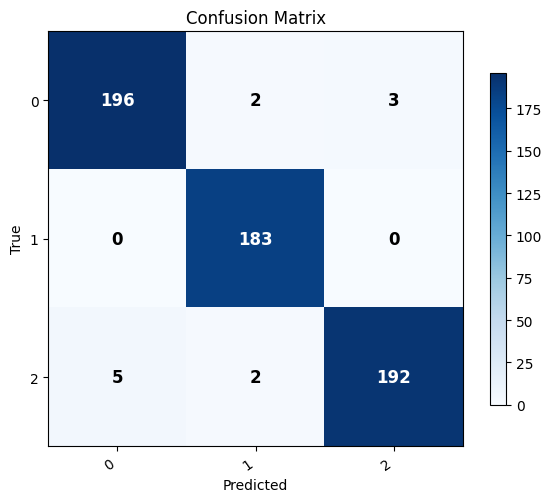

In [ ]:
from lib.metrics import plot_confusion_matrix
plot_confusion_matrix(cm, LABEL_NAMES)

#### 🗺️ How to read the heatmap

The heatmap is a visual representation of the same confusion matrix shown as a table above. Here's how to read it:

- **Rows** = true (actual) class, **Columns** = predicted class
- **Dark diagonal** = correct predictions. The darker/higher the diagonal values, the better.
- **Off-diagonal cells** = misclassifications. If cell `(Hotel, Flight)` were dark, it would mean the model often confuses hotel bookings for flight bookings.
- **Color intensity** maps to count — darker blue means more samples fell into that cell.

In our case the heatmap should show a clean diagonal pattern (all predictions correct). In more challenging scenarios, the heatmap immediately reveals patterns like "car rentals often get confused with hotels" — which would suggest those two classes have similar sentence patterns and might need more training data or better features to distinguish.